In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print("Using {} device".format(device))

Using cuda device


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
# Normalize: r, g, b 세 채널에 대해서 mean, std 로 맞춰줌
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


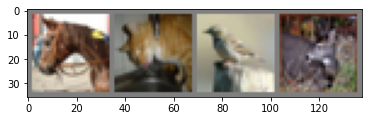

horse   cat  bird  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [9]:
# shape: batch size, channel, width, height
print(type(images), images.shape)
print(3 * 32 * 32)

<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
3072


In [11]:
print(type(labels), labels.shape)
print(labels)

<class 'torch.Tensor'> torch.Size([4])
tensor([7, 3, 2, 4])


In [19]:
class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layer = n_layer
    self.act = act
    
    self.fc = nn.Linear(self.in_dim, self.hid_dim)
    self.linears = nn.ModuleList()
    
    for i in range(self.n_layer-1):
        self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
    self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
    
    if self.act == 'relu':
        self.act = nn.ReLU()
    # 사용할 activation function을 추가할 수 있다... 
    # else로 오류 구문을 띄울 수 있다...
          
  def forward(self, x):
    # 주로 act 와 fc 등을 한 줄에 쓴다 -> 한 층을 구분하기 쉽다.
    x = self.act(self.fc(x))
    for fc in self.linears:
        x = self.act(fc(x))
    x = self.fc2(x) # 마지막에는 activation 하지 않는다.
    return x
      
net = MLP(3072, 10, 100, 4, 'relu')
print(net)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [35]:
net = MLP(3072, 10, 100, 4, 'relu').to(device)

# 위에 이것을 정의해줘서 여기서 정의해주지 않았더니
# 값이 cpu, cuda 에 둘다 있다는 오류 떴다. optimizer.step() 여기서 뜸.
# optimizer 에 지금 cuda에 올라간 model parameter가 아니라
# 저 위 model 의 parameter 들어가서 그런듯

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.view(-1, 3072)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.224
[1,  4000] loss: 1.919
[1,  6000] loss: 1.791
[1,  8000] loss: 1.704
[1, 10000] loss: 1.658
[2,  2000] loss: 1.619
[2,  4000] loss: 1.596
[2,  6000] loss: 1.544
[2,  8000] loss: 1.536
[2, 10000] loss: 1.517
[3,  2000] loss: 1.455
[3,  4000] loss: 1.446
[3,  6000] loss: 1.437
[3,  8000] loss: 1.452
[3, 10000] loss: 1.441
[4,  2000] loss: 1.353
[4,  4000] loss: 1.367
[4,  6000] loss: 1.379
[4,  8000] loss: 1.367
[4, 10000] loss: 1.364
[5,  2000] loss: 1.285
[5,  4000] loss: 1.320
[5,  6000] loss: 1.318
[5,  8000] loss: 1.312
[5, 10000] loss: 1.295
[6,  2000] loss: 1.224
[6,  4000] loss: 1.252
[6,  6000] loss: 1.259
[6,  8000] loss: 1.252
[6, 10000] loss: 1.277
[7,  2000] loss: 1.180
[7,  4000] loss: 1.194
[7,  6000] loss: 1.223
[7,  8000] loss: 1.209
[7, 10000] loss: 1.226
[8,  2000] loss: 1.135
[8,  4000] loss: 1.168
[8,  6000] loss: 1.184
[8,  8000] loss: 1.156
[8, 10000] loss: 1.182
[9,  2000] loss: 1.105
[9,  4000] loss: 1.120
[9,  6000] loss: 1.145
[9,  8000] 

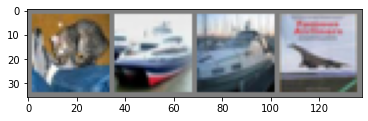

GroundTruth:    cat  ship  ship plane


In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [36]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 3072)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d? %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51? %


In [38]:
correct = 0
total = 0
val_loss = 0

with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 3072)
        outputs = net(images)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss /= len(valloader)
print(val_loss)
print('Accuracy of the network on the 10000 val images: %d? %%' % (
    100 * correct / total))

1.4319583303242922
Accuracy of the network on the 10000 val images: 51? %


In [42]:
def experiment(args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.to(device)
    print(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times

        # ==== Train ===== #
        net.train()
        
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

            # get the inputs
            inputs, labels = data
            inputs = inputs.view(-1, 3072)
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                

        # ==== Validation ====== #
        net.eval()
        # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
        
        correct = 0
        total = 0
        val_loss = 0 
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
            
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))


    # ===== Evaluation ===== #
    net.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    return train_loss, val_loss, val_acc, test_acc

In [43]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")


args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 2


list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.205
[1,  4000] loss: 1.889
[1,  6000] loss: 1.776
[1,  8000] loss: 1.712
[1, 10000] loss: 1.693
Epoch 0, Train Loss: 18549.877285778522, Val Loss: 1.7002450821876527, Val Acc: 38.49
[2,  2000] loss: 1.602
[2,  4000] loss: 1.605
[2,  6000] loss: 1.591
[2,  8000] loss: 1.593
[2, 10000] loss: 1.554
Epoch 1, Train Loss: 15889.999788239598, Val Loss: 1.5249510835886002, Val Acc: 45.66
(15889.999788239598, 1.5249510835886002, 45.66, 46.27)
MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out